# 다음과 같은 라이브러리 버전을 사용합니다.

In [1]:
import transformers
print(transformers.__version__) # 4.8.1 for KoBERT

4.8.1


In [2]:
import torch
print(torch.__version__)

1.9.0+cu111


# 1. Huggingface - pipeline

- 가장 간단한 사용법부터 알아봅시다. transformers의 `pipeline` 함수로 많은 것을 할 수 있어요 ([참고링크](https://huggingface.co/docs/transformers/main/en/main_classes/pipelines))


| **Task**                     | **Description**                                                                                              | **Modality**    | **Pipeline identifier**                       |
|------------------------------|--------------------------------------------------------------------------------------------------------------|-----------------|-----------------------------------------------|
| Text classification          | assign a label to a given sequence of text                                                                   | NLP             | pipeline(task=“sentiment-analysis”)           |
| Text generation              | generate text given a prompt                                                                                 | NLP             | pipeline(task=“text-generation”)              |
| Summarization                | generate a summary of a sequence of text or document                                                         | NLP             | pipeline(task=“summarization”)                |
| Image classification         | assign a label to an image                                                                                   | Computer vision | pipeline(task=“image-classification”)         |
| Image segmentation           | assign a label to each individual pixel of an image (supports semantic, panoptic, and instance segmentation) | Computer vision | pipeline(task=“image-segmentation”)           |
| Object detection             | predict the bounding boxes and classes of objects in an image                                                | Computer vision | pipeline(task=“object-detection”)             |
| Audio classification         | assign a label to some audio data                                                                            | Audio           | pipeline(task=“audio-classification”)         |
| Automatic speech recognition | transcribe speech into text                                                                                  | Audio           | pipeline(task=“automatic-speech-recognition”) |
| Visual question answering    | answer a question about the image, given an image and a question                                             | Multimodal      | pipeline(task=“vqa”)                          |
| Document question answering  | answer a question about a document, given an image and a question                                            | Multimodal      | pipeline(task="document-question-answering")  |
| Image captioning             | generate a caption for a given image                                                                         | Multimodal      | pipeline(task="image-to-text")                |

- `pipeline()`함수는 전처리(preprocessing), 모델로 입력 전달, 후처리(postprocessing)의 3단계를 한번에 실행합니다. 

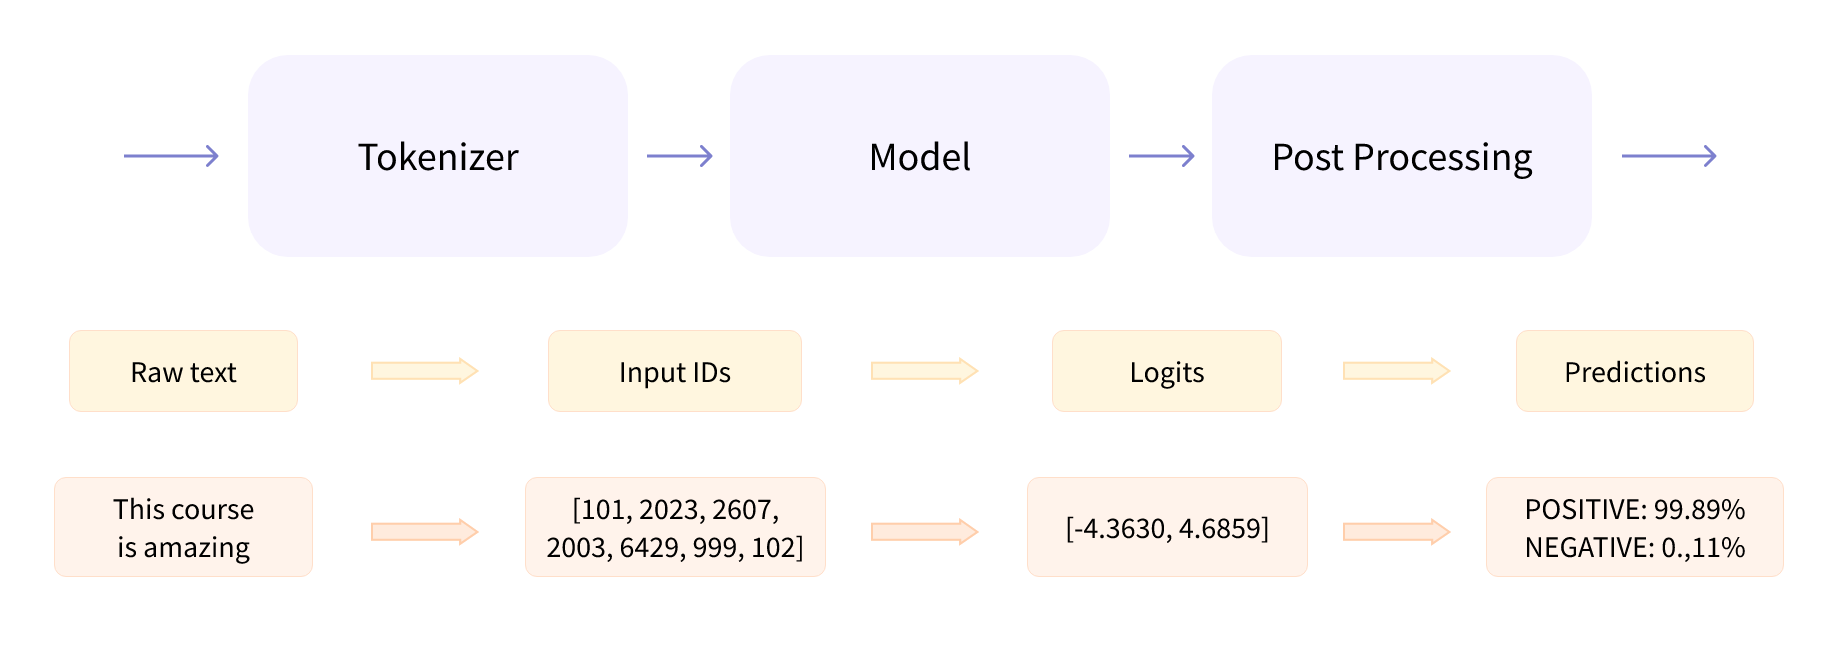
- 출처: https://wikidocs.net/166795 

- 먼저 감성분석을 위한 분류기를 가져와봅시다

In [4]:
from transformers import pipeline

# build pipeline
classifier = pipeline("sentiment-analysis") # default: distilbert-base-uncased-finetuned-sst-2-english

- 단일 문장에 대한 inference는 아래처럼 입력해 수행할 수 있습니다

In [5]:
print(classifier("What the hell"))
print(classifier("아오 빡쳐")) # 영어로 훈련된 모델이라 한국어는 인식하지 못합니다

[{'label': 'NEGATIVE', 'score': 0.997704029083252}]
[{'label': 'POSITIVE', 'score': 0.9143629670143127}]


- 여러 문장도 리스트로 전달해 inference할 수 있습니다

In [6]:
results = classifier(["We are very happy to show you the 🤗 Transformers library.", "We hope you don't hate it."])

for result in results:
    print(f"label: {result['label']}, with score: {round(result['score'], 4)}")

label: POSITIVE, with score: 0.9998
label: NEGATIVE, with score: 0.5309


- 우리가 만들고자 하는 다중 감성 분류 모델은 아직 배포된 한국어 모델이 없습니다. 원하는 라벨링도 다 다를거구요. 
- zero-shot classification 모델을 가져 할 수 있지만, 다중분류에서 성능을 기대하기는 어려운 것 같아요
- 성능이 모델의 크기와 비례한다는 한계도 있어요
- zero shot + 한국어 only 모델은 아직 없네요

In [7]:
clf_zeroshot = pipeline("zero-shot-classification") # bart-large-mnli
clf_zeroshot( "You are a very nice person",
                candidate_labels = ["Happy", "Depressed", "Angry", "Fear", "Love", "Surprised", "Neutral"])

{'sequence': 'You are a very nice person',
 'labels': ['Surprised',
  'Happy',
  'Neutral',
  'Love',
  'Fear',
  'Depressed',
  'Angry'],
 'scores': [0.38335248827934265,
  0.2624613046646118,
  0.24058350920677185,
  0.0726047232747078,
  0.019103646278381348,
  0.01426919735968113,
  0.007625153288245201]}

# 2. pipeline이 하는 작업을 나눠 보자

- `pipeline()`만 가지고 다중감성분류는 할 수 없는 것 같고, pretrained 모델을 fine tuning할 필요가 있습니다
- `pipeline()`이 전처리(preprocessing), 모델로 입력 전달, 후처리(postprocessing)를 한 번에 수행한다고 했는데, 각각이 어떻게 동작하는지 살펴보죠

## 1) Preprocessing - Tokenizer

- Tokenizing: 텍스트를 컴퓨터가 인식할 수 있는 숫자로 바꿔주는 작업
- `AutoTokenizer`를 사용해 일반적인 모델의 tokenizer를 가져올 수 있습니다

In [8]:
from transformers import AutoTokenizer

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english" # 사전학습모델을 가져와 중간부터 tuning을 시작한다는 의미로,checkpoint 라는 변수를 사용합니다. 
tokenizer = AutoTokenizer.from_pretrained(checkpoint, model_max_length=512)

- padding : input text가 여러개면 가장 긴 문장에 토큰 길이를 맞추는데, 그 토큰 길이보다 짧은 텍스트는 나머지를 0으로 padding해줘요. input text의 길이가 다른데 False로 설정하면 tensor가 생성되지 않습니다.
- truncation : 토큰의 길이가 model_max_length를 벗어났을 때 단어를 자를지 안자를지 결정합니다.
- 두 옵션 모두 True로 줘야 원활한 tuning이 가능합니다.

In [9]:
raw_inputs = [
    "I've been waiting for a HuggingFace course my whole life.",
    "I hate this so much!",
]
inputs = tokenizer(raw_inputs, padding=True, truncation=True, return_tensors="pt")
print(inputs)

{'input_ids': tensor([[  101,  1045,  1005,  2310,  2042,  3403,  2005,  1037, 17662, 12172,
          2607,  2026,  2878,  2166,  1012,   102],
        [  101,  1045,  5223,  2023,  2061,  2172,   999,   102,     0,     0,
             0,     0,     0,     0,     0,     0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]])}


- KoBERT 모델의 경우 Tokenizer를 따로 제공해요

In [10]:
from kobert import get_tokenizer
from kobert import get_pytorch_kobert_model
from kobert_tokenizer import KoBERTTokenizer

checkpoint = "skt/kobert-base-v1" 
tokenizer = KoBERTTokenizer.from_pretrained(checkpoint, model_max_length=512)

In [11]:
raw_inputs = "걔는 성격 진짜 나쁘던데? It's ridiculous. 다시는 상종하기 싫어"
inputs = tokenizer(raw_inputs, padding=True, truncation=True, return_tensors="pt") # pytorch tensor 반환
print(inputs)

{'input_ids': tensor([[   2,  517,    0, 5760, 2782, 4368, 1370, 6488, 5842, 5850,  258,  655,
          442,   15,  440,  517,  438,  388,  406,  447,  427,  451,   54, 1574,
         5760, 2658, 7268, 7789, 3059,    3]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1]])}


- tokenizer가 하는 일을 자세히 봅시다.

In [12]:
# sequnece를 tokenize해줍니다.(문장을 최소의미단위로 잘라줍니다)
# 결과를 보니 KoBERT를 사용할 때는 영어를 모두 제거해주는게 좋겠네요.
tokens = tokenizer.tokenize(raw_inputs)
print(tokens)

['▁', '걔', '는', '▁성격', '▁진짜', '▁나', '쁘', '던', '데', '?', '▁I', 't', "'", 's', '▁', 'ri', 'd', 'ic', 'ul', 'o', 'us', '.', '▁다시', '는', '▁상', '종', '하기', '▁싫어']


In [13]:
# token을 id로 바꿔줍니다
ids = tokenizer.convert_tokens_to_ids(tokens)
print(ids)

[517, 0, 5760, 2782, 4368, 1370, 6488, 5842, 5850, 258, 655, 442, 15, 440, 517, 438, 388, 406, 447, 427, 451, 54, 1574, 5760, 2658, 7268, 7789, 3059]


In [14]:
# id를 다시 디코딩
decoded_string = tokenizer.decode(ids)
print(decoded_string)

[UNK]는 성격 진짜 나쁘던데? It's ridiculous. 다시는 상종하기 싫어


In [15]:
type(inputs)

transformers.tokenization_utils_base.BatchEncoding

## 2) Input token(s) into a model


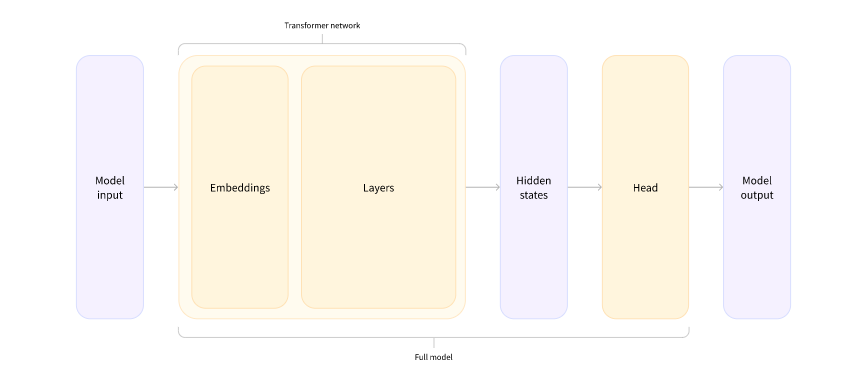

- 모델을 불러와 inputs을 넣어줍니다
- inputs는 엄밀하게 정의하면 dictionary는 아니지만('BatchEncoding'이라는 transformers 라이브러리에서 자체 정의한 타입) dictionary처럼 생겼습니다. `**`로 value를 넣어줄 수 있어요.
- outputs.last_hidden_state.shape은 다음을 의미해요
- [1, 12, 768]: [batch_size, sequence_length, hidden_size] ([링크](https://huggingface.co/docs/transformers/main/en/main_classes/output#transformers.modeling_outputs.SequenceClassifierOutput))
- batch_size는 input으로 들어온 문장 개수, sequence_length는 토큰의 길이, hidden_size는 학습 결과로 배우는 feature 개수를 의미합니다. 

In [16]:
from transformers import AutoModel
checkpoint = "skt/kobert-base-v1" 
model = AutoModel.from_pretrained(checkpoint)

outputs = model(**inputs)
print(outputs.last_hidden_state.shape)

torch.Size([1, 30, 768])


- 768개의 feature를 사용해서 뭔가 해야겠죠. 그냥 모델에 넣어봤자 의미없는 결과가 나올겁니다.
- AutoModelForSequenceClassification로 분류를 해봅시다.
- outputs.logits.shape의 결과는 1개의 문장을 통해 2개 class로 예측하겠다는 뜻입니다

In [17]:
from transformers import AutoModelForSequenceClassification

checkpoint = "skt/kobert-base-v1" 
model = AutoModelForSequenceClassification.from_pretrained(checkpoint)
outputs = model(**inputs)
print(outputs.logits.shape)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at skt/kobert-base-v1 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


torch.Size([1, 2])


## 3) Post-processing

- outputs로 나온 결과를 사람이 이해할 수 있는 값으로 줘야겠죠?
- 그냥 출력해보면 outputs의 값이 logit으로 나오네요 (logit = log + odds)

In [18]:
print(outputs)

SequenceClassifierOutput(loss=None, logits=tensor([[-0.0076, -0.0243]], grad_fn=<AddmmBackward>), hidden_states=None, attentions=None)


- softmax 함수로 확률화 시켜줍시다 (범위: [0,1])

In [19]:
import torch
predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
print(predictions)

tensor([[0.5042, 0.4958]], grad_fn=<SoftmaxBackward>)


# 3. Transfer learning with Huggingface

- 필요한 최소한의 지식이 생긴 것 같습니다. 한번 전체 프로세스를 진행해봅시다
- 목표: multiple sentiment analysis

In [1]:
import torch
from transformers import AdamW, AutoModelForSequenceClassification
from kobert_tokenizer import KoBERTTokenizer

checkpoint = "skt/kobert-base-v1" 
tokenizer = KoBERTTokenizer.from_pretrained(checkpoint)

# 사전학습 언어모델 인스턴스화 
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=7)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at skt/kobert-base-v1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


- 데이터를 불러옵니다

In [2]:
from datasets import load_dataset
data_name = "sent_merge" 

dataset = load_dataset('csv', data_files={'train': f'../data_split/{data_name}_train.csv',
                                          'test': f'../data_split/{data_name}_test.csv'})
dataset

Using custom data configuration default-8e80763ffbac1bee
Reusing dataset csv (/root/.cache/huggingface/datasets/csv/default-8e80763ffbac1bee/0.0.0/9144e0a4e8435090117cea53e6c7537173ef2304525df4a077c435d8ee7828ff)


DatasetDict({
    train: Dataset({
        features: ['id', 'text', 'label'],
        num_rows: 43853
    })
    test: Dataset({
        features: ['id', 'text', 'label'],
        num_rows: 10964
    })
})

- 전처리 함수를 작성해 적용합니다
- 결측값 제거, 특수문자 제거, 토크나이징

In [3]:
# 결측값 제거
import pandas as pd

dataset = dataset.filter(lambda row: pd.notnull(row["id"]))
dataset = dataset.filter(lambda row: pd.notnull(row["text"]))
dataset = dataset.filter(lambda row: pd.notnull(row["label"]))

Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/default-8e80763ffbac1bee/0.0.0/9144e0a4e8435090117cea53e6c7537173ef2304525df4a077c435d8ee7828ff/cache-7d46d2613c1bc41a.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/default-8e80763ffbac1bee/0.0.0/9144e0a4e8435090117cea53e6c7537173ef2304525df4a077c435d8ee7828ff/cache-05259dc511dece38.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/default-8e80763ffbac1bee/0.0.0/9144e0a4e8435090117cea53e6c7537173ef2304525df4a077c435d8ee7828ff/cache-6b41264358b44366.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/default-8e80763ffbac1bee/0.0.0/9144e0a4e8435090117cea53e6c7537173ef2304525df4a077c435d8ee7828ff/cache-9830456025cb629c.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/default-8e80763ffbac1bee/0.0.0/9144e0a4e8435090117cea53e6c7537173ef2304525df4a077c435d8ee7828ff/cache-0711df7d795adcf4.arrow
Loadi

* load_dataset 함수로 불러온 데이터를 수정할 때는 수정 내용을 담은 함수를 만들고, 이를 map 함수로 각 원소에 적용함 ([링크](https://huggingface.co/docs/datasets/v1.4.0/processing.html#processing-data-row-by-row)에서 확인)

In [4]:
# 특수문자 제거
import re

def remove_sp(example):
    example["text"]=re.sub(r'[^0-9|ㄱ-ㅎ|ㅏ-ㅣ|가-힣| ]+', '', str(example["text"]))
    return example

dataset = dataset.map(remove_sp)

Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/default-8e80763ffbac1bee/0.0.0/9144e0a4e8435090117cea53e6c7537173ef2304525df4a077c435d8ee7828ff/cache-78bcddde5c8466bf.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/default-8e80763ffbac1bee/0.0.0/9144e0a4e8435090117cea53e6c7537173ef2304525df4a077c435d8ee7828ff/cache-00e9d9f678cd987f.arrow


In [5]:
# 토크나이즈
# Tokenizer 옵션은 https://huggingface.co/docs/transformers/main/en/main_classes/tokenizer#transformers.PreTrainedTokenizer 참고

checkpoint = "skt/kobert-base-v1" 
tokenizer = KoBERTTokenizer.from_pretrained(checkpoint, truncation_side = 'right')

def tokenize_fn(dataset):
    tokenized_batch = tokenizer(dataset["text"],
                                padding="max_length",
                                truncation=True,
                                max_length = 256)
    return tokenized_batch
    
dataset = dataset.map(tokenize_fn, batched=True) # 여러 텍스트가 포함된 하나의 배치 단위로 인코딩

Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/default-8e80763ffbac1bee/0.0.0/9144e0a4e8435090117cea53e6c7537173ef2304525df4a077c435d8ee7828ff/cache-3122ad59de55b9c0.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/default-8e80763ffbac1bee/0.0.0/9144e0a4e8435090117cea53e6c7537173ef2304525df4a077c435d8ee7828ff/cache-c7cf389fcdf0c2f1.arrow


In [6]:
# train / eval / test
import math

seed = 7353
train_proportion = 0.7

train_dataset = dataset["train"].shuffle(seed=seed).select(range(0,math.floor(len(dataset["train"])*train_proportion)))
eval_dataset = dataset["train"].shuffle(seed=seed).select(range(math.floor(len(dataset["train"])*train_proportion), len(dataset["train"])))
test_dataset = dataset["test"]

Loading cached shuffled indices for dataset at /root/.cache/huggingface/datasets/csv/default-8e80763ffbac1bee/0.0.0/9144e0a4e8435090117cea53e6c7537173ef2304525df4a077c435d8ee7828ff/cache-dd3027c613c8fa9c.arrow
Loading cached shuffled indices for dataset at /root/.cache/huggingface/datasets/csv/default-8e80763ffbac1bee/0.0.0/9144e0a4e8435090117cea53e6c7537173ef2304525df4a077c435d8ee7828ff/cache-dd3027c613c8fa9c.arrow


- `Trainer`에서 사용할 하이퍼파라미터를 `TrainingArguments` 클래스에 정의해줘야 합니다. 
- Hyperparameter는 임의로 static한 값을 지정했습니다.

In [7]:
from transformers import TrainingArguments

args = TrainingArguments(
    output_dir="./",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    num_train_epochs=3,
    weight_decay=0.01
)

In [8]:
# 평가 매트릭을 정의해줍니다. 
import numpy as np
from sklearn.metrics import accuracy_score, f1_score

def _compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    f1_weighted = f1_score(labels, predictions, average = 'weighted')
    acc_weighted = accuracy_score(labels, predictions)
    return {"acc_weighted": acc_weighted, "f1_weighted": f1_weighted, "objective": acc_weighted + f1_weighted}

In [ ]:
# data_collator 정의
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer) # 배치단위로 패딩 수행할 수 있도록 해줌

In [9]:
# transformers.Trainer를 사용하려면 huggingface hub에서 토큰을 발급받아야합니다.
# from huggingface_hub import notebook_login

# notebook_login()

In [10]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=data_collator,
    compute_metrics=_compute_metrics,
    tokenizer=tokenizer,
)

trainer.train()

The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text, id.
***** Running training *****
  Num examples = 30697
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 11514


Epoch,Training Loss,Validation Loss,Acc Weighted,F1 Weighted,Objective
1,0.933700,0.953975,0.663043,0.648124,1.311168
2,0.767000,0.953160,0.666236,0.660185,1.326421
3,0.621300,0.985900,0.673685,0.669881,1.343566


The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text, id.
***** Running Evaluation *****
  Num examples = 13156
  Batch size = 8
Saving model checkpoint to ./checkpoint-3838
Configuration saved in ./checkpoint-3838/config.json
Model weights saved in ./checkpoint-3838/pytorch_model.bin
tokenizer config file saved in ./checkpoint-3838/tokenizer_config.json
Special tokens file saved in ./checkpoint-3838/special_tokens_map.json
The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text, id.
***** Running Evaluation *****
  Num examples = 13156
  Batch size = 8
Saving model checkpoint to ./checkpoint-7676
Configuration saved in ./checkpoint-7676/config.json
Model weights saved in ./checkpoint-7676/pytorch_model.bin
tokenizer config file saved in ./checkpoint-7676/tokenizer_config.json
Special tokens fi

TrainOutput(global_step=11514, training_loss=0.8277763056427898, metrics={'train_runtime': 1087.7545, 'train_samples_per_second': 84.662, 'train_steps_per_second': 10.585, 'total_flos': 1.3040759334809088e+16, 'train_loss': 0.8277763056427898, 'epoch': 3.0})

In [11]:
# save the pretrained model
trainer.model.save_pretrained("./my_model")

Configuration saved in ./my_model/config.json
Model weights saved in ./my_model/pytorch_model.bin


- evaluation

In [12]:
# model test
trainer.evaluate()

The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text, id.
***** Running Evaluation *****
  Num examples = 13156
  Batch size = 8


{'eval_loss': 0.9858995079994202,
 'eval_acc_weighted': 0.6736850106415324,
 'eval_f1_weighted': 0.6698807508425041,
 'eval_objective': 1.3435657614840366,
 'eval_runtime': 38.9073,
 'eval_samples_per_second': 338.137,
 'eval_steps_per_second': 42.28,
 'epoch': 3.0}

- Test

In [17]:
pred = trainer.predict(test_dataset=test_dataset)

The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text, id.
***** Running Prediction *****
  Num examples = 10964
  Batch size = 8


In [19]:
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, precision_score, recall_score, f1_score

label_test = list(pred.label_ids)
pred_test = list(map(lambda x: x.index(max(x)), pred.predictions.tolist()))
print(confusion_matrix(label_test, pred_test))

[[1443  209   52   39    0    0   86]
 [ 133 2805  211  357    0    0   47]
 [  68  545 1791  166    0    0  193]
 [  55  587  121 1051    0    0   86]
 [   4    4    0    0    0    0    0]
 [   0    1    0    1    0    0    1]
 [  94   97  262  107    0    0  348]]


In [20]:
accuracy = accuracy_score(label_test, pred_test)
f1 = f1_score(label_test, pred_test, average = 'weighted')
recall = recall_score(label_test, pred_test, average = 'weighted')
precision = precision_score(label_test, pred_test, average = 'weighted')

print(accuracy)
print(f1)
print(recall)
print(precision)

0.6784020430499818
0.6745459355197292
0.6784020430499818
0.6768423897978051


/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


- Huggingface 편하긴 한데.. 보완이 필요합니다.
- Confusion Matrix에서 보다시피 LABEL_4, LABEL_5로 분류된 데이터가 0개입니다
- 우리가 사용한 데이터는 imbalaced data 이고, 아마 편향된 모델이 만들어졌을 겁니다.
- 우리는 임의의 hyperparameter를 사용했어요.
- class weight를 보정해주면 좋을 것 같고, 
- Hyperparameter 최적화가 필요해 보여요.

# Ref

- https://huggingface.co/docs/transformers/main/en/main_classes/pipelines (Huggingface official docs)
- https://wikidocs.net/166795 (Huggingface wikidocs)